# NIRSpec IFU Optimal Point Source Extraction

This notebook illustrates various extraction methods for a point source in JWST NIRSpec IFU data, utilizing the [Q3D](https://q3d.github.io/) (PID 1335) observation of quasar SDSS J165202.64+172852.3. The extraction techniques include subset extraction with Cubeviz, simple sum over spaxels, cylindrical aperture, conical aperture photometry, and optimal point source extraction using a WebbPSF model PSF. 

**Use case:** optimal spectral extraction; method by [Horne (1986)](https://ui.adsabs.harvard.edu/abs/1986PASP...98..609H/abstract).

**Data:** JWST NIRSpec IFU data; point sources.

**Tools:**  jwst, webbpsf, matplotlib, scipy, custom functions.

**Cross-intrument:** any spectrograph. 

**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis).

## Table of Contents
1. [Imports](#imports)
2. [Read in NIRSpec IFU Cube](#read)
3. [Visualize Science Data with Cubeviz](#visualize)
4. [Export Source and Good Data Regions from Cubeviz](#source)
5. [Extract Subset Spectrum and Background from Cubeviz Spectrum Viewer](#viewer)
6. [Extract Spectrum by Sum over Spaxels](#sum)
7. [Extract Spectrum in Constant Radius Circular Aperture (Cylinder)](#cylinder)
8. [Extract Spectrum in Linearly Expanding Circular Aperture (Cone)](#cone)
9. [Plot and Compare Non-optimal Spectral Extractions](#plot)
10. [WebbPSF Model for Optimal Extraction](#webbpsf)
11. [Align Model PSF Cube with Science Data](#align)
12. [Optimal Extraction Using WebbPSF Model](#optimal)

## 1. Imports <a id="imports"/>

* _numpy_ for array math
* _scipy_ for ndimage shift
* _specutils_ for Spectrum1D data model
* _jdaviz_ : for data visualization
* _photutils_ to define circular apertures
* _astropy.io_ for reading and writing FITS cubes and images
* _astropy.wcs, units, coordinates_ for defining and reading WCS
* _astropy.stats_ for sigma_clipping
* _astropy.utils_ for downloading files from URLs
* _matplotlib_ for plotting spectra and images
* _os_ for file management
* _astroquery.mast_ to download the data

In [1]:
import numpy as np
import scipy
from specutils import Spectrum1D
import jdaviz
from jdaviz import Cubeviz, Specviz
print("jdaviz Version={}".format(jdaviz.__version__))
from photutils.aperture import CircularAperture, aperture_photometry 
from astropy.io import fits
from astropy import wcs
from astropy import units as u
import os
from astroquery.mast import Observations

jdaviz Version=3.8.0


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## 2. Read in NIRSpec IFU Cube <a id="read"/>

The NIRSpec IFU observation of quasar SDSS J1652+1728 (redshift z=1.9) was taken using the G235H grating with F170LP filter, covering 1.66-3.17 microns at a spectral resolution of R~2700. The IFU spaxels are 0.1" on a side. 
The level-3 pipeline_processed datacube (s3d.fits, which combines all dithered exposures) is retrieved from MAST 
in the next notebook cell  below.

In [3]:
# Download the data file
uri = "mast:jwst/product/jw01335-o008_t007_nirspec_g235h-f170lp_s3d.fits"
result = Observations.download_file(
    uri, base_url="https://mast.stsci.edu/api/v0.1/Download/file"
)
if result[0] == "ERROR":
    raise RuntimeError("Error retrieving file: " + result[1])

# Construct the local filepath
filename = os.path.join(os.path.abspath("."), uri.rsplit("/", 1)[-1])

# Optionally Replace MAST data with custom reprocessed data in the current directory
# filename="./jw01335-o008_t007_nirspec_g235h-f170lp_s3d.fits"

INFO: Found cached file /home/runner/work/jdat_notebooks/jdat_notebooks/notebooks/ifu_optimal/jw01335-o008_t007_nirspec_g235h-f170lp_s3d.fits with expected size 102585600. [astroquery.query]


In [4]:
# Open and inspect the file and WCS
with fits.open(filename, memmap=False) as hdulist:
    sci = hdulist["SCI"].data
    err = hdulist["ERR"].data
    w = wcs.WCS(hdulist[1].header)
    hdr = hdulist[1].header
    print(w)

# Window the wavelength range to focus on Hbeta-[OIII]
spec1d = Spectrum1D.read(filename)
slice_range = range(500, 1100, 1)
wavelength = np.array(spec1d.spectral_axis.value)[slice_range[0]: slice_range[-1] + 1]

# List of cube slices for aperture photometry
sci_data = []
sci_var = []
for idx in slice_range:
    sci_data.append(sci[idx, :, :])
    sci_var.append(err[idx, :, :])

data = np.nan_to_num(np.array(sci_data))
var = np.array(sci_var)
print("\nTrimmed data shape:", data.shape)

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN' 'DEC--TAN' 'WAVE' 
CRVAL : -106.98898425200001 17.481222214 1.6601979666156693e-06 
CRPIX : 22.0 20.0 1.0 
PC1_1 PC1_2 PC1_3  : -1.0 0.0 0.0 
PC2_1 PC2_2 PC2_3  : 0.0 1.0 0.0 
PC3_1 PC3_2 PC3_3  : 0.0 0.0 1.0 
CDELT : 2.77777781916989e-05 2.77777781916989e-05 3.95999988541007e-10 
NAXIS : 43  39  3814

Trimmed data shape: (600, 39, 43)


In [5]:
cubeviz = Cubeviz()
cubeviz.load_data(filename)
cubeviz.show()

# Set spectrum display limits
cubeviz.specviz.x_limits(1.65 * u.um, 2.4 * u.um)
cubeviz.specviz.y_limits(0.0, 5.0e3)

# Select slice to visualize
cubeviz.select_slice(714)

Application(config='cubeviz', docs_link='https://jdaviz.readthedocs.io/en/v3.8.0/cubeviz/index.html', events=[…

## 3. Visualize Science Data with Cubeviz <a id="visualize"/>

<img src="sdssj1652_nirspec_ifu_cubeviz.png" alt="Cubeviz, an astronomy data analysis viewer, showing two image panels with a central bright object and a spectral graph panel displaying numerous peaks across various wavelengths" width="600"/>

### UI Instructions:
* Scrub through the cube to a line-free region using the spectrum-viewer slice tool.
* In the flux-viewer, select one circular subset region centered on the quasar, and a square region to delimit the good area for spectral and background extraction
* Note that the regions are pixelated and don't include fractional pixels
* The default collapse method is "Sum" in the spectrum viewer (see Plot Options:Line). "Median" may also be useful for visualization but will not give an accurate measurement of the total flux.)

## 4. Export Source and Good Data Regions from Cubeviz <a id="source"/>
Export the region defined by the user in Cubeviz as astropy PixelRegions

In [6]:
try:
    print("\nSource Region")
    region1 = cubeviz.get_interactive_regions()['Subset 1']
    print(region1)
    center_xy = [region1.center.x, region1.center.y]
    r_pix = region1.radius
    region1_exists = True
except Exception:
    print("There is no Subset 1 selected in the cube viewer.")
    center_xy = [17.1, 20.0]
    r_pix = 5.92
    print("Using default pixel center and radius:")
    print("Center pixel:", center_xy)
    print("Radius (pixels):", r_pix)
    region1_exists = False
    
print("\nGood Data Region")
try:
    region2 = cubeviz_data.get_selection_definition(
        "Subset 2", format="astropy-regions"
    )
    print(region2)
    region2_exists = True
    data_xrange = [
        round(region2.center.x - region2.width / 2),
        round(region2.center.x + region2.width / 2),
    ]
    data_yrange = [
        round(region2.center.y - region2.height / 2),
        round(region2.center.y + region2.height / 2),
    ]
    print("Good data (xmin,xmax), (ymin,ymax):", data_xrange, data_yrange)
    good_data = np.nan_to_num(
        data[:, data_yrange[0]: data_yrange[1], data_xrange[0]: data_xrange[1]]
    )
    good_var = var[:, data_yrange[0]: data_yrange[1], data_xrange[0]: data_xrange[1]]

except Exception:
    print("There is no Subset 2 selected in the cube viewer.")
    region1_exists = False
    data_xrange = [7, 36]
    data_yrange = [6, 33]
    good_data = np.nan_to_num(
        data[:, data_yrange[0]: data_yrange[1], data_xrange[0]: data_xrange[1]]
    )
    good_var = var[:, data_yrange[0]: data_yrange[1], data_xrange[0]: data_xrange[1]]
    print("Using default good data (xmin,xmax), (ymin,ymax):", data_xrange, data_yrange)


Source Region
There is no Subset 1 selected in the cube viewer.
Using default pixel center and radius:
Center pixel: [17.1, 20.0]
Radius (pixels): 5.92

Good Data Region
There is no Subset 2 selected in the cube viewer.
Using default good data (xmin,xmax), (ymin,ymax): [7, 36] [6, 33]


## 5. Extract Subset Spectrum and Background from Cubeviz Spectrum Viewer <a id="viewer"/>
Retrieve the collapsed spectrum (Subset1) of the user-defined region from the Spectrum Viewer as a Spectrum1D object.

In [7]:
subsets = cubeviz.specviz.get_spectra()
print(subsets.keys())

print("\nSource")
try:
    spectrum_subset1 = cubeviz.get_data(cubeviz.app.data_collection[0].label,
                                        spatial_subset="Subset 1", function="mean")
    print(spectrum_subset1)
except Exception:
    print("There is no Subset 1 selected in the spectrum viewer.")

print("\nBackground")
try:
    spectrum_subset2 = spectrum_subset2 = subsets[
        [i for i in subsets.keys() if "Subset 2" in i][0]
    ]
    print(spectrum_subset2)
except Exception:
    print("There is no Subset 2 selected in the spectrum viewer.")

dict_keys(['jw01335-o008_t007_nirspec_g235h-f170lp_s3d[SCI]'])

Source
There is no Subset 1 selected in the spectrum viewer.

Background
There is no Subset 2 selected in the spectrum viewer.


/usr/share/miniconda/lib/python3.11/site-packages/jdaviz/configs/specviz/helper.py:131: UserWarning: Applying the value from the redshift slider to the output spectra. To avoid seeing this warning, explicitly set the apply_slider_redshift keyword option to True or False.
  warnings.warn("Applying the value from the redshift "


*Developer Note:* The units of the Cubeviz "Sum" collapse method (and all other spectra below) need to be multiplied by the pixel area in sr to yield flux units (MJy) instead of surface brightness units (MJy/sr).

## 6. Extract Spectrum by Sum Over Spaxels <a id="sum"/>

Perform a simple numpy sum over all spaxels in the cube as a rudimentary extraction method. Also sum over wavelength to collapse the cube.

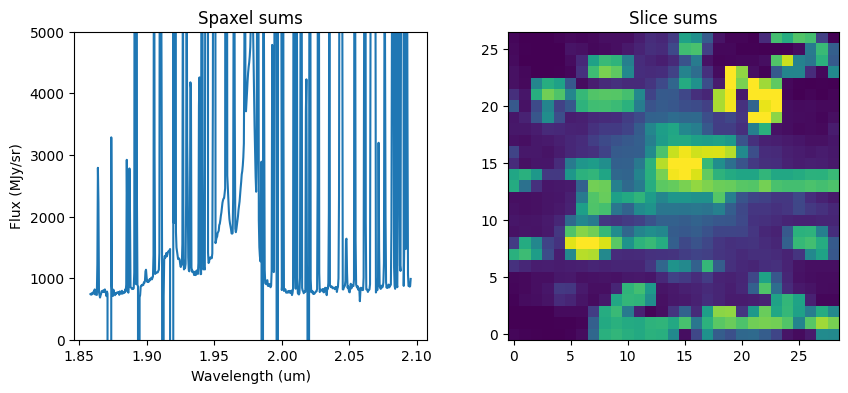

In [8]:
# Sum over wavelength
# Clip data for display purposes
clip_level = 4e4
data_clipped = np.clip(good_data, 0, clip_level)
cube_sum = np.sum(data_clipped, axis=0)

# Extraction via sum over spaxels
fnu_sum = np.sum(good_data, axis=(1, 2))
fnu_sum_clipped = np.clip(fnu_sum, 0, clip_level)
flux_spaxsum = np.array(fnu_sum) * u.MJy / u.sr
spec1d_spaxsum = Spectrum1D(spectral_axis=wavelength * u.um, flux=flux_spaxsum)

# Plots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(wavelength, fnu_sum)
ax1.set_title("Spaxel sums")
ax1.set_xlabel("Wavelength (um)")
ax1.set_ylabel("Flux (MJy/sr)")
ax1.set_ylim(0, 5e3)
ax2.imshow(cube_sum, norm=LogNorm(vmin=100, vmax=clip_level), origin="lower")
ax2.set_title("Slice sums")

plt.show()

## 7. Extract Spectrum in Constant Radius Circular Aperture (Cylinder) <a id="cylinder" />
This method is appropriate for an extended source.

In [9]:
# CircularAperture uses xy pixels
aperture = CircularAperture(center_xy, r=r_pix)
print(aperture)

cylinder_sum = []
for slice2d in data:
    phot_table = aperture_photometry(slice2d, aperture)
    cylinder_sum.append(phot_table["aperture_sum"][0])

flux_cylinder = np.array(cylinder_sum) * u.MJy / u.sr
spec1d_cylinder = Spectrum1D(spectral_axis=wavelength * u.um, flux=flux_cylinder)

Aperture: CircularAperture
positions: [17.1, 20. ]
r: 5.92


*Developer Note:*  Is there a way to retrieve the coordinates (RA, Dec) of the Subset1 region, for use in a SkyCircularAperture?

## 8. Extract Spectrum in Linearly Expanding Circular Aperture (Cone) <a id = "cone" />
This method is appropriate for a point source PSF with width proportional to wavelength

In [10]:
# Reference wavelength for expanding aperture
lambda0 = wavelength[0]
print("Reference wavelength:", lambda0)

cone_sum = []
idx = -1
for (slice2d, wave) in zip(data, wavelength):
    idx = idx + 1
    r_cone = r_pix * wave / lambda0

    aperture_cone = CircularAperture(center_xy, r=r_cone)
    phot_table = aperture_photometry(
        slice2d, aperture_cone, wcs=w.celestial, method="exact"
    )
    cone_sum.append(phot_table["aperture_sum"][0])

flux_cone = np.array(cone_sum) * u.MJy / u.sr
spec1d_cone = Spectrum1D(spectral_axis=wavelength * u.um, flux=flux_cone)

Reference wavelength: 1.858197960886173


## 9. Plot and Compare Non-optimal Spectral Extractions <a id = "plot" />
Compare spectra extracted in cylinder, cone, Cubeviz subset.

There is no Cubeviz Subset1 spectrum to plot.


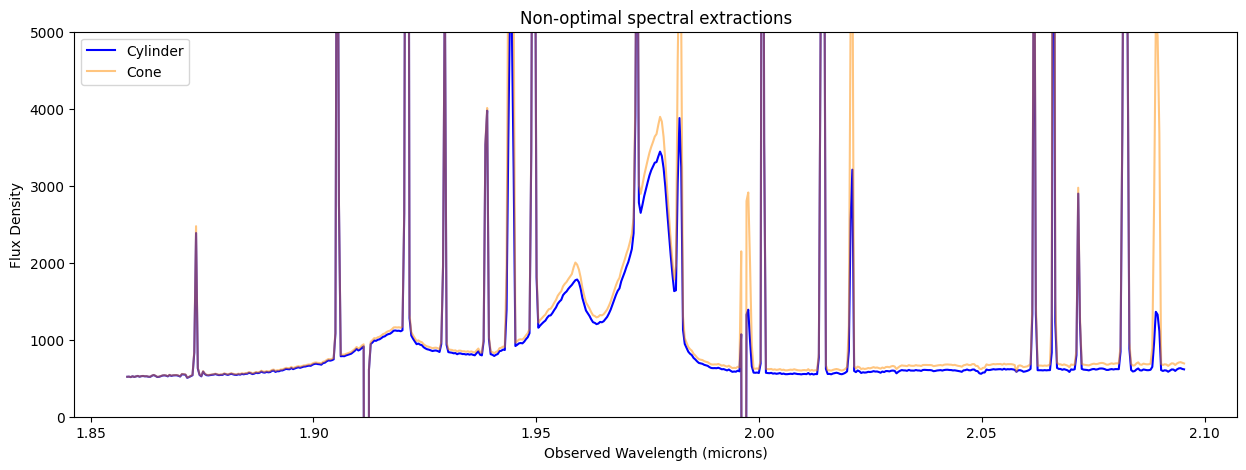

In [11]:
f, (ax1) = plt.subplots(1, 1, figsize=(15, 5))

# ax1.plot(wavelength, flux_spaxsum.value, label="All spaxels", c='k')
ax1.plot(wavelength, flux_cylinder.value, label="Cylinder", c="b")
ax1.plot(wavelength, flux_cone.value, label="Cone", c="darkorange", alpha=0.5)
try:
    ax1.plot(
        wavelength,
        spectrum_subset1.flux.value[slice_range[0]: slice_range[-1] + 1],
        c="r",
        label="Subset1",
        alpha=0.4,
    )
except Exception:
    print("There is no Cubeviz Subset1 spectrum to plot.")

ax1.set_title("Non-optimal spectral extractions")
ax1.set_xlabel("Observed Wavelength (microns)")
ax1.set_ylabel("Flux Density")
ax1.set_ylim(0, 5.0e3)
ax1.legend()
plt.show()

The non-optimal cylindrical, conical, and CubeViz subset spectral extractions are quite similar. 
The conical extraction captures more flux at long wavelengths.
Red-shifted Broad H-beta and narrow [O III] lines  are visible in the quasar spectra. 

## 10. WebbPSF  Model PSF for Optimal Extraction <a id="webbpsf" />
Generate PSF model cube using WebbPSF for NIRSpec IFU, or read in precomputed PSF model cube.

WebbPSF installation instructions can be found in [ReadTheDocs](https://webbpsf.readthedocs.io/en/latest/).

Caution! The WebbPSF model takes about 10 hr to run.  Uncomment the following cell to do so. Otherwise, read in the precomputed WebbPSF model, which covers the full wavelength range of the present NIRSpec G235H dataset. For other filter/grating combinations, uncomment and run the cell below using the wavelengths from the science data set.

In [12]:
# #WebbPSF imports
# %pylab inline
# import webbpsf
#
# #WebbPSF commands used to create PSF model cube
# ns = webbpsf.NIRSpec()
# ns.image_mask = "IFU"  # Sets to 3x3 arcsec square mask

# wavelengths = wavelength*1.0E-6
# psfcube = ns.calc_datacube(wavelengths, fov_pixels=30, oversample=4,  add_distortion=True)
# psfcube.writeto("Webbpsf_ifucube.fits")

In [13]:
BoxPath = "https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_optimal_extraction/"
psf_filename = BoxPath + "Webbpsf_ifucube.fits"

# Open WebbPSF data cube
with fits.open(psf_filename, memmap=False) as hdulist:
    psf_model = hdulist["DET_SAMP"].data
    psf_hdr = hdulist["DET_SAMP"].header
    hdulist.info()

# Pad PSF model cube with zeros to match the present dataset
# (Different padding may be needed for your particular dataset)
print(sci.shape, psf_model.shape)
psf_model_padded = np.pad(psf_model, ((0, 0), (4, 5), (6, 7)), "constant")

# Sum over wavelength
psf_model_sum = np.sum(psf_model_padded[slice_range[0]: slice_range[-1] + 1], axis=0)

# Sum over spaxels
psf_model_fnusum = np.sum(
    psf_model_padded[slice_range[0]: slice_range[-1] + 1], axis=(1, 2)
)

Filename: /home/runner/.astropy/cache/download/url/4931b72fec159f8a439e8c80c181370f/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU   105786   (120, 120, 3915)   float64   
  1  DET_SAMP      1 ImageHDU     105788   (30, 30, 3915)   float64   
  2  OVERDIST      1 ImageHDU     105831   (120, 120, 3915)   float64   
  3  DET_DIST      1 ImageHDU     105832   (30, 30, 3915)   float64   
(3814, 39, 43) (3915, 30, 30)


*Developer Note:*  The file Webbpsf_ifucube.fits is large (946.3 MB) and takes some time to load from Box.
It might behoove the user to download it to a local directory and retrieve it from there.

## 11. Align Model PSF Cube with Science Data <a id="align"/>
Flip, smooth, and shift the model PSF cube to align with the simulated data. Trim the simulated data.  

Important Note 1: this PSF will likely be rotated with respect to your dataset, depending on telescope roll angle.  You can either rotate it to match your data or reprocess your data using the ifualign keyword to align the WCS with the instrumental coordinate frame.

Important Note 2: this PSF will likely be shifted with respect to your dataset. It would be beneficial to automatically find the (x,y) offset between the data and simulated PSF peaks.  Currently the shift is determined empirically by eye.

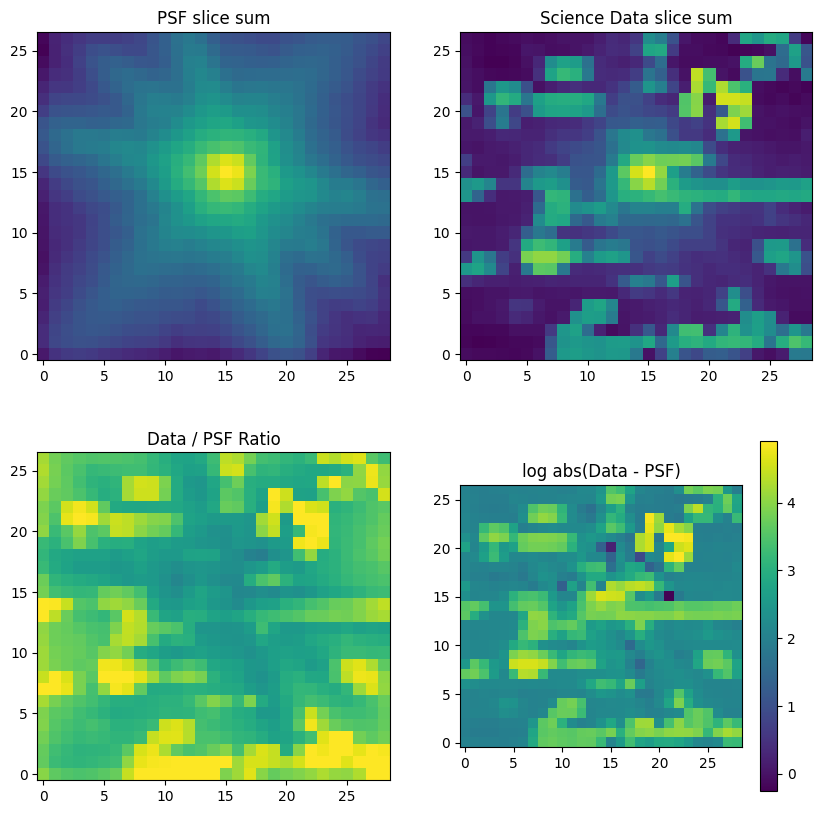

In [14]:
# Flip model PSF left-right to match data.
psf_model_fliplr = psf_model_padded[:, ::-1, :]

# Empirically (chi-by-eye) determined shift
shiftx = 1.5  # 2
shifty = 1.5  # 1.5

# Shift model PSF using linear interpolation
psf_model_aligned = scipy.ndimage.shift(
    psf_model_fliplr,
    (0.0, shiftx, shifty),
    order=1,
    mode="constant",
    cval=0.0,
    prefilter=True,
)

good_psf_model = psf_model_aligned[
    slice_range[0]: slice_range[-1] + 1,
    data_yrange[0]: data_yrange[1],
    data_xrange[0]: data_xrange[1],
]

# Sum over wavelength
psf_model_sum = np.sum(good_psf_model, axis=0)

# Scale factor for PSF subtraction
psf_sum_max = np.amax(psf_model_sum)
scalefactor = np.amax(cube_sum) / psf_sum_max

# Plots
f, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(10, 10))

ax1.set_title("PSF slice sum")
ax1.imshow(psf_model_sum, norm=LogNorm(), origin="lower")

ax2.set_title("Science Data slice sum")
ax2.imshow(cube_sum, norm=LogNorm(), origin="lower")

ax3.set_title("Data / PSF Ratio")
ax3.imshow(cube_sum / psf_model_sum, norm=LogNorm(vmin=1, vmax=1e6), origin="lower")

im4 = ax4.imshow(
    np.log10(np.absolute(cube_sum - 0.75 * scalefactor * psf_model_sum)), origin="lower"
)
plt.colorbar(im4)
ax4.set_title("log abs(Data - PSF)")

plt.show()

_Figure top row_: Comparison of shifted WebbPSF PSF (left) to science data (right).  The NIRSpec IFU PSF is signficantly different from the WebbPSF simulation for the telescope. This is partly due to the IFU optics and perhaps partly due to the cube building algorithm. There is also some real extended emission from the QSO host and surrounding galaies.

_Figure bottom row_:  Differences between the model PSF and the observed PSF will result in a sub-optimal extraction, not quite attaining the maximum SNR, but still better than a sum over all spaxels.

## 12. Optimal Extraction using WebbPSF Model <a id="optimal" />
Optimal extraction ([Horne 1986, PASP, 98, 609](https://ui.adsabs.harvard.edu/abs/1986PASP...98..609H/abstract)) weights the flux contributions to a spectrum by their signal-to-noise ratio (SNR). Dividing the simulated data by the model PSF gives an estimate of the total flux density spectrum in each spaxel. A weighted average of these estimates over all spaxels yields the optimally extracted spectrum over the cube. In the faint source limit, where the noise is background-dominated, optimal extraction inside a 3-sigma radius can increase the effective exposure time by a factor of 1.69 (Horne et al. 1986). In the bright source limit, where the noise is dominated by the Poisson statistics of the source, optimal extraction is formally identical to a straight sum over spaxels for a perfect PSF model. 

We use the precomputed WebbPSF PSF model for optimal extraction here.

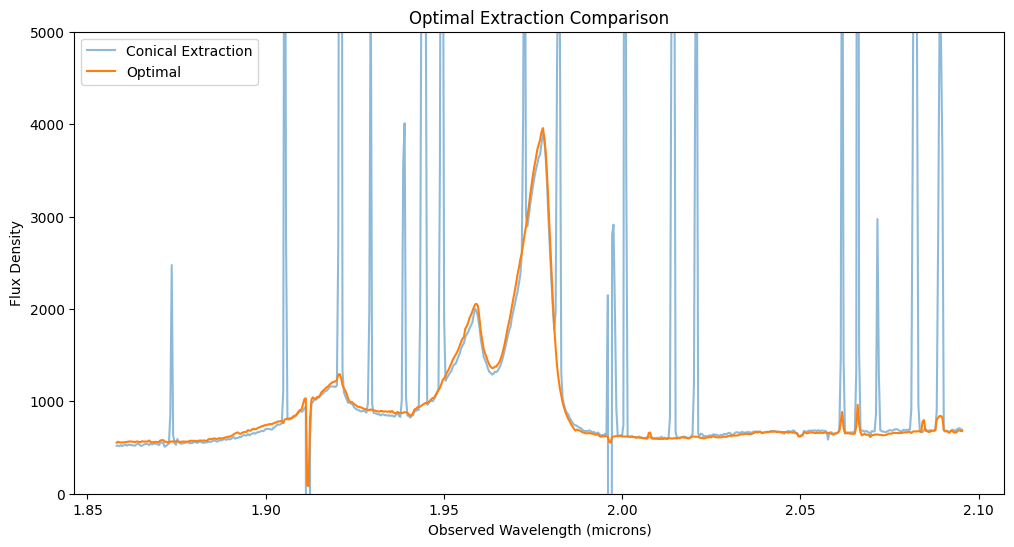

In [15]:
# Window PSF model (and replace NaNs)
good_profile = np.nan_to_num(good_psf_model)
var_clean = np.nan_to_num(good_var, nan=1e12, posinf=1e12, neginf=1e12)
zerovar = np.where(var_clean == 0)
var_clean[zerovar] = 1e12
var_clean_sum = np.sum(var_clean, axis=(0))
snr_clean = np.nan_to_num(good_data / var_clean)

# Divide data by PSF model
data_norm = np.nan_to_num(good_data / good_profile, posinf=0, neginf=0)
data_norm_sum = np.sum(data_norm, axis=0)

# Mask out bad data
# data_norm_clipped = sigma_clip(data_norm, sigma=3.0, maxiters=5, axis=(1, 2))
data_norm_clipped = data_norm
data_norm_clipped_sum = np.sum(data_norm_clipped, axis=0)
snr_thresh = 1.0
badvoxel = np.where((data_norm_clipped == 0) | (snr_clean < snr_thresh))
data_clean = 1.0 * good_data
data_clean[badvoxel] = 0.0
data_clean_sum = np.sum(data_clean, axis=0)

# Optimal extraction, using model profile weight and variance cube from the simulated data
optimal_weight = np.nan_to_num(
    good_profile**2 / var_clean, posinf=0, neginf=0
)  # Replace nans and infs with 0
optimal_weight_sum = np.sum(optimal_weight, axis=(0))
optimal_weight_norm = np.sum(optimal_weight, axis=(1, 2))
spectrum_optimal = (
    np.sum(good_profile * data_clean / var_clean, axis=(1, 2)) / optimal_weight_norm
)

# Plots
f, (ax1) = plt.subplots(1, 1, figsize=(12, 6))
ax1.set_title("Optimal Extraction Comparison")
ax1.set_xlabel("Observed Wavelength (microns)")
ax1.set_ylabel("Flux Density")
ax1.set_ylim(0, 5000)
ax1.plot(wavelength, cone_sum, label="Conical Extraction", alpha=0.5)
ax1.plot(wavelength, spectrum_optimal, label="Optimal")
ax1.legend()
plt.show()

In [16]:
specviz = Specviz()

flux_opt = spectrum_optimal * u.MJy / u.sr
spec1d_opt = Spectrum1D(spectral_axis=wavelength * u.um, flux=flux_opt)

# specviz.load_data(spec1d_spaxsum, data_label="collapse spec")
specviz.load_data(spec1d_opt, data_label="optimal spec")
specviz.load_data(spec1d_cone, data_label="cone spec")
specviz.show()

# set spectrum display limits
# specviz.x_limits()
specviz.y_limits(0.0, clip_level / 7)

Application(config='specviz', docs_link='https://jdaviz.readthedocs.io/en/v3.8.0/specviz/index.html', events=[…

The optimally extracted spectrum is less noisy than the aperture extraction and incorporates fewer bad pixels and cosmic ray events. The OIII line profile is different because extended emission is downweighted with respect to the unresolved quasar nucleus.

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>

Notebook created by Patrick Ogle and James Davies. Last update: December 2023.